In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

column_names = ['Frequency', 'S11_real', 'S11_imag', 'S21_real', 'S21_imag', 'S12_real', 'S12_imag', 'S22_real', 'S22_imag']

df = pd.read_csv("/content/drive/MyDrive/compiled_s_parameters.csv")
print(df.head())
print(df.tail())

Mounted at /content/drive
     Frequency  S11_real  S11_imag  S21_real  S21_imag  S12_real  S12_imag  \
0  150000000.0  0.999581 -0.017274 -0.000068  0.003711 -0.000197  0.002876   
1  200000000.0  0.999773 -0.022917 -0.000445  0.004304  0.000066  0.004540   
2  250000000.0  0.999480 -0.028811  0.000598  0.005652  0.000257  0.005739   
3  300000000.0  0.998839 -0.034925  0.000645  0.006661  0.000504  0.006547   
4  350000000.0  0.998923 -0.040521  0.000579  0.007655  0.000185  0.008006   

   S22_real  S22_imag  Drain Voltage  Gate Voltage  
0 -0.194988 -0.001711            0.0          -4.0  
1 -0.195059 -0.001605            0.0          -4.0  
2 -0.194959 -0.002238            0.0          -4.0  
3 -0.194624 -0.003261            0.0          -4.0  
4 -0.194737 -0.003503            0.0          -4.0  
          Frequency  S11_real  S11_imag  S21_real  S21_imag  S12_real  \
60755  4.330000e+10 -0.174898 -0.386970  0.401390  0.294518  0.140165   
60756  4.335000e+10 -0.164484 -0.380100  

In [ ]:
df.describe()

,Frequency,S11_real,S11_imag,S21_real,S21_imag,S12_real,S12_imag,S22_real,S22_imag,Drain Voltage,Gate Voltage
count,6.076000e+04,60760.000000,60760.000000,60760.000000,60760.000000,60760.000000,60760.000000,60760.000000,60760.000000,60760.00000,60760.000000
mean,2.182500e+10,0.199791,-0.510623,-0.247884,0.752500,0.121201,0.035390,0.535566,-0.260609,8.50000,-2.924286
std,1.252860e+10,0.422961,0.162620,0.653742,0.303386,0.066704,0.044674,0.241684,0.088531,2.82845,1.431837
min,1.500000e+08,-0.467111,-0.958287,-1.815632,-0.028003,-0.000434,-0.134165,-0.308115,-0.691079,0.00000,-5.000000
25%,1.098750e+10,-0.161333,-0.642664,-0.738636,0.559766,0.070913,0.003520,0.377331,-0.327240,8.50000,-4.000000
50%,2.182500e+10,0.061961,-0.524022,-0.007171,0.765161,0.135755,0.042079,0.515895,-0.282772,10.00000,-3.650000
75%,3.266250e+10,0.548578,-0.411805,0.306935,0.987178,0.165853,0.070535,0.731201,-0.218516,10.00000,-1.700000
max,4.350000e+10,1.000406,-0.009927,0.593229,1.438814,0.371832,0.157606,0.959126,0.017057,10.00000,0.000000


In [ ]:
vg_target = -4
subset_vg = df[df['Gate Voltage'] == vg_target]

if subset_vg.empty:
    print(f"No data found for Gate Voltage = {vg_target} V")
else:
    vd_min = subset_vg['Drain Voltage'].min()
    vd_max = subset_vg['Drain Voltage'].max()
    print(f"At VG = {vg_target} V: Min VD = {vd_min}, Max VD = {vd_max}")

At VG = -4 V: Min VD = 0.0, Max VD = 10.0


In [ ]:
def check_train_test_shapes_for_vg_fixed(vg_fixed=-4, vd_train_max=8):
    # Filter for fixed VG
    subset_vg = df[df['Gate Voltage'] == vg_fixed]
    if subset_vg.empty:
        print(f"No data found for VG = {vg_fixed} V")
        return

    # Split based on VD threshold
    train_set = subset_vg[subset_vg['Drain Voltage'] <= vd_train_max]
    test_set  = subset_vg[subset_vg['Drain Voltage'] > vd_train_max]

    print(f"Train Set Shape (VD ≤ {vd_train_max}): {train_set.shape}")
    print(f"Test Set Shape (VD > {vd_train_max}): {test_set.shape}")

In [ ]:
check_train_test_shapes_for_vg_fixed(vg_fixed=-4, vd_train_max=7)

Train Set Shape (VD ≤ 7): (13020, 11)
Test Set Shape (VD > 7): (6076, 11)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1. Load and initial noise filter (Frequency ≤ 1.6e10)
df = pd.read_csv("/content/drive/MyDrive/compiled_s_parameters.csv")
df_vg = df[(df['Frequency'] <= 1.6e10) & (df['Gate Voltage'] == -4)]

# 2. Train/test split for VD ∈ [0, 8] & Frequency ≤ 1.4e10
vd_max = 7
train_mask = (
    (df_vg['Drain Voltage'] >= 0) &
    (df_vg['Drain Voltage'] <= vd_max) &
    (df_vg['Frequency'] <= 1.4e10)
)
train_df = df_vg[train_mask]
test_df  = df_vg[~train_mask]

print("Train set shape:", train_df.shape)
print("Test set shape: ", test_df.shape)

# 3. Prepare features & targets
#    Now features = [Frequency, Drain Voltage] since VG is fixed
X_train = train_df[['Frequency', 'Drain Voltage']].values
X_test  = test_df[['Frequency', 'Drain Voltage']].values

y_train = train_df[['S11_real', 'S11_imag']].values
y_test  = test_df[['S11_real', 'S11_imag']].values

# 4. Scale inputs & outputs
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_s = scaler_x.transform(X_train)
X_test_s  = scaler_x.transform(X_test)
y_train_s = scaler_y.transform(y_train)
y_test_s  = scaler_y.transform(y_test)

# 5. Build dual-output ANN for S11_real & S11_imag
def build_s11_model():
    inp = layers.Input(shape=(2,))
    x = layers.Dense(64, activation='swish')(inp)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dense(64, activation='swish')(x)
    out_r = layers.Dense(1, name='real')(x)
    out_i = layers.Dense(1, name='imag')(x)
    m = models.Model(inputs=inp, outputs=[out_r, out_i])
    m.compile(optimizer='adam', loss='mse')
    return m

model_vd = build_s11_model()
es_vd = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# 6. Train
history_vd = model_vd.fit(
    X_train_s,
    [y_train_s[:,0], y_train_s[:,1]],
    validation_split=0,
    epochs=100,
    batch_size=8,
    callbacks=[es_vd],
    verbose=1
)

# 7. Predict & un-scale
pred_r_vd, pred_i_vd = model_vd.predict(X_test_s)
pred_scaled_vd = np.hstack([pred_r_vd, pred_i_vd])
pred_vd = scaler_y.inverse_transform(pred_scaled_vd)
pred_real_vd, pred_imag_vd = pred_vd[:,0], pred_vd[:,1]

true_real_vd, true_imag_vd = y_test[:,0], y_test[:,1]

# 8. Compute error metrics
def mean_relative_error(a, b):
    return np.mean(np.abs((a - b) / (a + 1e-12)))

mre_real = mean_relative_error(true_real_vd, pred_real_vd)
mae_real = mean_absolute_error(true_real_vd, pred_real_vd)
mse_real = mean_squared_error(true_real_vd, pred_real_vd)

mre_imag = mean_relative_error(true_imag_vd, pred_imag_vd)
mae_imag = mean_absolute_error(true_imag_vd, pred_imag_vd)
mse_imag = mean_squared_error(true_imag_vd, pred_imag_vd)

print("\n=== VG = -4V, VD ∈ [0,8] Train/Test Split ===")
print(f"S11_real → MRE: {mre_real:.6f}, MAE: {mae_real:.6f}, MSE: {mse_real:.6f}")
print(f"S11_imag → MRE: {mre_imag:.6f}, MAE: {mae_imag:.6f}, MSE: {mse_imag:.6f}")


Train set shape: (4170, 11)
Test set shape:  (2826, 11)
Epoch 1/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - imag_loss: 0.1390 - loss: 0.2642 - real_loss: 0.1253
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: imag_loss,loss,real_loss
  current = self.get_monitor_value(logs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0093 - loss: 0.0202 - real_loss: 0.0109
Epoch 3/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0091 - loss: 0.0193 - real_loss: 0.0102
Epoch 4/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0077 - loss: 0.0177 - real_loss: 0.0100
Epoch 5/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0074 - loss: 0.0179 - real_loss: 0.0105
Epoch 6/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0069 - loss: 0.0166 - real_loss: 0.0097
Epoch 7/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - imag_loss: 0.0060 - loss: 0.0149 - real_loss: 0.0090
Epoch 8/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0057 - loss: 0.0150 - real_loss: 0.0093
Epoch 9/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0057 - loss: 0.0152 - real_loss: 0.0094
Epoch 10/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0054 - loss: 0.0145 - real_loss: 0.0091
Epoch 11/100
522/522 ━━━━━━━━━━━━━━━━━━

In [ ]:
def plot_and_eval_for_vd(vd_value, tol=1e-6):
    # Filter for fixed VG = -4, given VD, and Frequency ≤ 1.6e10
    subset = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.6e10)
    ]

    if subset.empty:
        print(f"No data found for Drain Voltage = {vd_value}V at VG = -4V")
        return

    # Prepare input for prediction
    X_sub = subset[['Frequency', 'Drain Voltage']].values
    Xs = scaler_x.transform(X_sub)

    # Predict using model_vd
    pred_r, pred_i = model_vd.predict(Xs, verbose=0)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y.inverse_transform(pred_scaled)
    pred_real, pred_imag = pred[:, 0], pred[:, 1]

    # Actual values
    actual_real = subset['S11_real'].values
    actual_imag = subset['S11_imag'].values
    freq = subset['Frequency'].values

    # Compute error metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    def mre(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

    real_mre = mre(actual_real, pred_real)
    imag_mre = mre(actual_imag, pred_imag)
    real_mae = mean_absolute_error(actual_real, pred_real)
    imag_mae = mean_absolute_error(actual_imag, pred_imag)
    real_mse = mean_squared_error(actual_real, pred_real)
    imag_mse = mean_squared_error(actual_imag, pred_imag)

    print(f"\n[VD = {vd_value}V, VG = -4V]")
    print(f"S11_real → MRE: {real_mre:.6f}, MAE: {real_mae:.6f}, MSE: {real_mse:.6f}")
    print(f"S11_imag → MRE: {imag_mre:.6f}, MAE: {imag_mae:.6f}, MSE: {imag_mse:.6f}")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freq, actual_real, 'o', label='Actual')
    plt.plot(freq, pred_real, 'x--', label='Predicted')
    plt.title(f'S11_real vs Frequency @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency')
    plt.ylabel('S11_real')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freq, actual_imag, 'o', label='Actual')
    plt.plot(freq, pred_imag, 'x--', label='Predicted')
    plt.title(f'S11_imag vs Frequency @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency')
    plt.ylabel('S11_imag')
    plt.legend()

    plt.tight_layout()
    plt.show()



[VD = 10V, VG = -4V]
S11_real → MRE: 0.015969, MAE: 0.008872, MSE: 0.000114
S11_imag → MRE: 0.047161, MAE: 0.009205, MSE: 0.000108


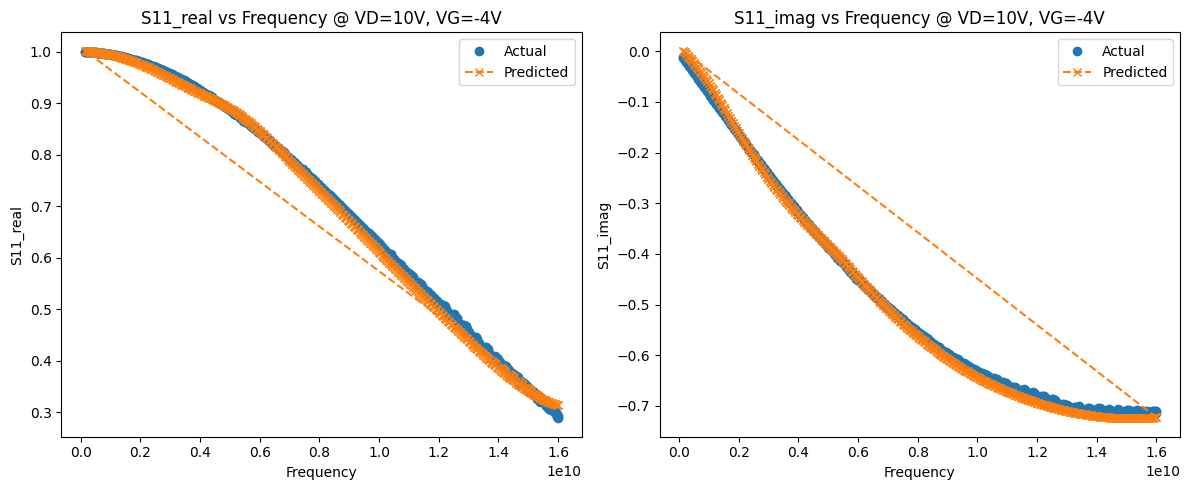

In [ ]:
plot_and_eval_for_vd(10)

In [ ]:
pip install scikit-rf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.2/609.2 kB 29.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from skrf.frequency import Frequency
from skrf.network import Network

def plot_smith_for_vd(vd_value, tol=1e-6):
    # Filter for VG = -4V and specified VD
    subset = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.6e10)
    ]
    if subset.empty:
        print(f"No data found for Drain Voltage = {vd_value} V at VG = -4V")
        return

    # True S11
    freq = subset['Frequency'].values
    s11_actual = subset['S11_real'].values + 1j * subset['S11_imag'].values

    # Predict S11 using model_vd
    X = subset[['Frequency', 'Drain Voltage']].values
    X_scaled = scaler_x.transform(X)
    pred_r, pred_i = model_vd.predict(X_scaled, verbose=0)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y.inverse_transform(pred_scaled)
    s11_pred = pred[:, 0] + 1j * pred[:, 1]

    # Convert to scikit-rf Networks
    freq_obj = Frequency.from_f(freq, unit='Hz')
    ntw_actual = Network(frequency=freq_obj, s=s11_actual.reshape(-1, 1, 1), name='Actual S11')
    ntw_pred = Network(frequency=freq_obj, s=s11_pred.reshape(-1, 1, 1), name='Predicted S11')

    # Plot on Smith chart
    plt.figure(figsize=(8, 8))
    ntw_actual.plot_s_smith(m=0, n=0, label='Actual S11', marker='o', markersize=5, markerfacecolor='blue', linestyle='None')
    ntw_pred.plot_s_smith(m=0, n=0, label='Predicted S11', marker='x', markersize=2, linestyle='None')
    plt.title(f'Smith Chart: VD = {vd_value} V, VG = -4 V')
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/skrf/frequency.py:275: InvalidFrequencyWarning: Frequency values are not monotonously increasing!
To get rid of the invalid values call `drop_non_monotonic_increasing`
  temp_freq.check_monotonic_increasing()


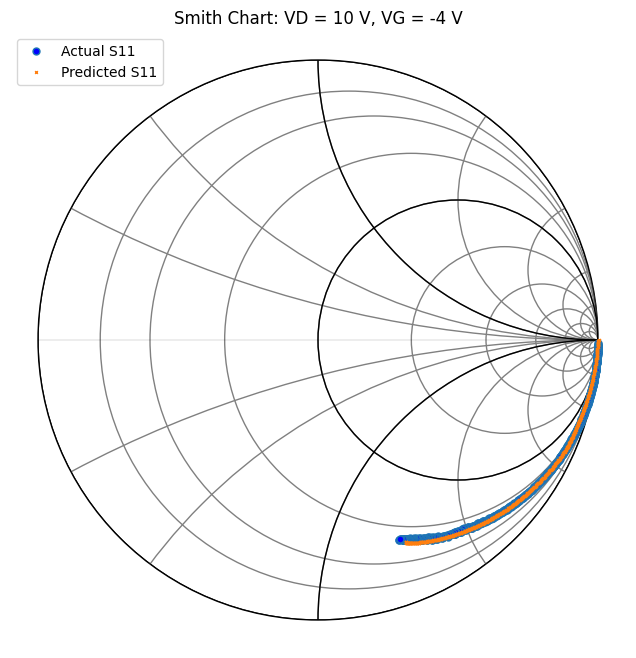

In [ ]:
plot_smith_for_vd(10)

In [ ]:
# === 1. Prepare S22 dataset for VG = -4V ===
X_train_s22 = X_train
X_test_s22 = X_test

y_train_s22 = train_df[['S22_real', 'S22_imag']].values
y_test_s22 = test_df[['S22_real', 'S22_imag']].values

# === 2. Scale ===
scaler_y_s22 = StandardScaler().fit(y_train_s22)
y_train_s22_s = scaler_y_s22.transform(y_train_s22)
y_test_s22_s = scaler_y_s22.transform(y_test_s22)

# === 3. Model & Train ===
model_s22 = build_s11_model()  # Reuse same architecture
es_s22 = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_s22 = model_s22.fit(
    X_train_s,
    [y_train_s22_s[:,0], y_train_s22_s[:,1]],
    validation_split=0,
    epochs=100,
    batch_size=8,
    callbacks=[es_s22],
    verbose=1
)

# === 4. Predict & Unscale ===
pred_r_s22, pred_i_s22 = model_s22.predict(X_test_s)
pred_scaled_s22 = np.hstack([pred_r_s22, pred_i_s22])
pred_s22 = scaler_y_s22.inverse_transform(pred_scaled_s22)
pred_real_s22, pred_imag_s22 = pred_s22[:,0], pred_s22[:,1]

true_real_s22, true_imag_s22 = y_test_s22[:,0], y_test_s22[:,1]

# === 5. Metrics ===
mre_real_s22 = mean_relative_error(true_real_s22, pred_real_s22)
mae_real_s22 = mean_absolute_error(true_real_s22, pred_real_s22)
mse_real_s22 = mean_squared_error(true_real_s22, pred_real_s22)

mre_imag_s22 = mean_relative_error(true_imag_s22, pred_imag_s22)
mae_imag_s22 = mean_absolute_error(true_imag_s22, pred_imag_s22)
mse_imag_s22 = mean_squared_error(true_imag_s22, pred_imag_s22)

print("\n=== VG = -4V, VD ∈ [0,8] Train/Test Split ===")
print(f"S22_real → MRE: {mre_real_s22:.6f}, MAE: {mae_real_s22:.6f}, MSE: {mse_real_s22:.6f}")
print(f"S22_imag → MRE: {mre_imag_s22:.6f}, MAE: {mae_imag_s22:.6f}, MSE: {mse_imag_s22:.6f}")


Epoch 1/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - imag_loss: 0.1930 - loss: 0.4082 - real_loss: 0.2153
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: imag_loss,loss,real_loss
  current = self.get_monitor_value(logs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - imag_loss: 0.0429 - loss: 0.0922 - real_loss: 0.0493
Epoch 3/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0289 - loss: 0.0559 - real_loss: 0.0271
Epoch 4/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0205 - loss: 0.0340 - real_loss: 0.0135
Epoch 5/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0140 - loss: 0.0233 - real_loss: 0.0093
Epoch 6/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - imag_loss: 0.0128 - loss: 0.0214 - real_loss: 0.0087
Epoch 7/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0113 - loss: 0.0183 - real_loss: 0.0070
Epoch 8/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0093 - loss: 0.0143 - real_loss: 0.0050
Epoch 9/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0090 - loss: 0.0145 - real_loss: 0.0055
Epoch 10/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0084 - loss: 0.0123 - real_loss: 0.0039
Epoch 11/100
522/522 ━━━━━━━━━━━━━━━━━━

In [ ]:
def plot_and_eval_for_vd_s22(vd_value, tol=1e-6):
    # Filter for fixed VG = -4, given VD, and Frequency ≤ 1.6e10
    subset = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.5e10)
    ]

    if subset.empty:
        print(f"No data found for Drain Voltage = {vd_value}V at VG = -4V")
        return

    # Prepare input for prediction
    X_sub = subset[['Frequency', 'Drain Voltage']].values
    Xs = scaler_x.transform(X_sub)

    # Predict using model_s22
    pred_r, pred_i = model_s22.predict(Xs, verbose=0)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y_s22.inverse_transform(pred_scaled)
    pred_real, pred_imag = pred[:, 0], pred[:, 1]

    # Actual values
    actual_real = subset['S22_real'].values
    actual_imag = subset['S22_imag'].values
    freq = subset['Frequency'].values

    # Compute error metrics
    def mre(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

    real_mre = mre(actual_real, pred_real)
    imag_mre = mre(actual_imag, pred_imag)
    real_mae = mean_absolute_error(actual_real, pred_real)
    imag_mae = mean_absolute_error(actual_imag, pred_imag)
    real_mse = mean_squared_error(actual_real, pred_real)
    imag_mse = mean_squared_error(actual_imag, pred_imag)

    print(f"\n[VD = {vd_value}V, VG = -4V]")
    print(f"S22_real → MRE: {real_mre:.6f}, MAE: {real_mae:.6f}, MSE: {real_mse:.6f}")
    print(f"S22_imag → MRE: {imag_mre:.6f}, MAE: {imag_mae:.6f}, MSE: {imag_mse:.6f}")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freq, actual_real, 'o', label='Actual')
    plt.plot(freq, pred_real, 'x--', label='Predicted')
    plt.title(f'S22_real vs Frequency @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency')
    plt.ylabel('S22_real')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freq, actual_imag, 'o', label='Actual')
    plt.plot(freq, pred_imag, 'x--', label='Predicted')
    plt.title(f'S22_imag vs Frequency @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency')
    plt.ylabel('S22_imag')
    plt.legend()

    plt.tight_layout()
    plt.show()



[VD = 10V, VG = -4V]
S22_real → MRE: 0.005094, MAE: 0.003905, MSE: 0.000027
S22_imag → MRE: 0.023933, MAE: 0.002657, MSE: 0.000013


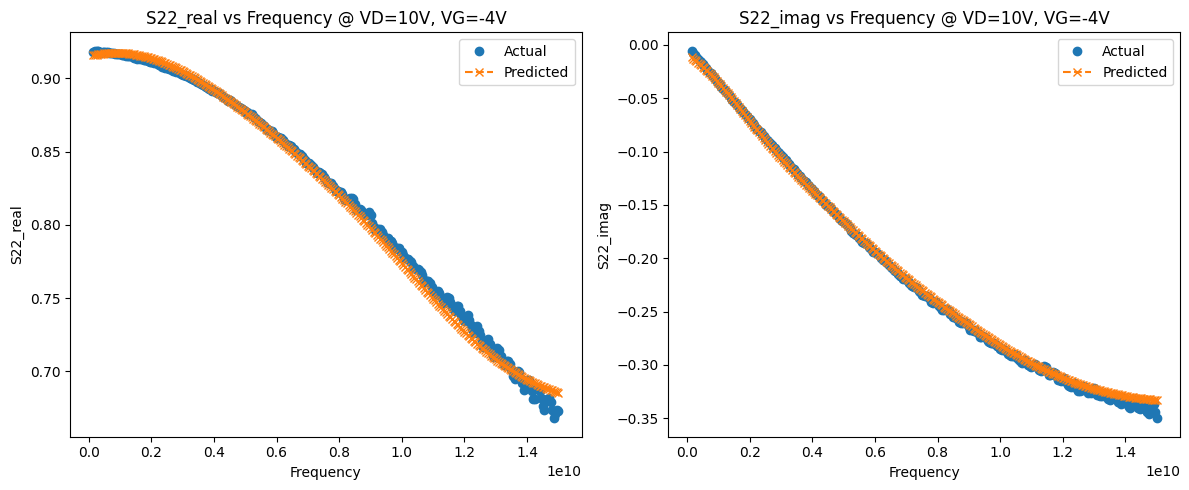

In [ ]:
plot_and_eval_for_vd_s22(7.5)

In [ ]:
def plot_smith_for_vd_s22(vd_value, tol=1e-6):
    # Filter for VG = -4V and specified VD
    subset = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.5e10)
    ]
    if subset.empty:
        print(f"No data found for Drain Voltage = {vd_value} V at VG = -4V")
        return

    # Actual S22
    freq = subset['Frequency'].values
    s22_actual = subset['S22_real'].values + 1j * subset['S22_imag'].values

    # Predict S22 using model_s22
    X = subset[['Frequency', 'Drain Voltage']].values
    X_scaled = scaler_x.transform(X)
    pred_r, pred_i = model_s22.predict(X_scaled, verbose=0)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y_s22.inverse_transform(pred_scaled)
    s22_pred = pred[:, 0] + 1j * pred[:, 1]

    # Convert to scikit-rf Networks
    freq_obj = Frequency.from_f(freq, unit='Hz')
    ntw_actual = Network(frequency=freq_obj, s=s22_actual.reshape(-1, 1, 1), name='Actual S22')
    ntw_pred = Network(frequency=freq_obj, s=s22_pred.reshape(-1, 1, 1), name='Predicted S22')

    # Plot on Smith chart
    plt.figure(figsize=(8, 8))
    ntw_actual.plot_s_smith(m=0, n=0, label='Actual S22', marker='o', markersize=6, markerfacecolor='green', linestyle='None')
    ntw_pred.plot_s_smith(m=0, n=0, label='Predicted S22', marker='x', markersize=2, linestyle='None')
    plt.title(f'Smith Chart: VD = {vd_value} V, VG = -4 V')
    plt.legend()
    plt.show()


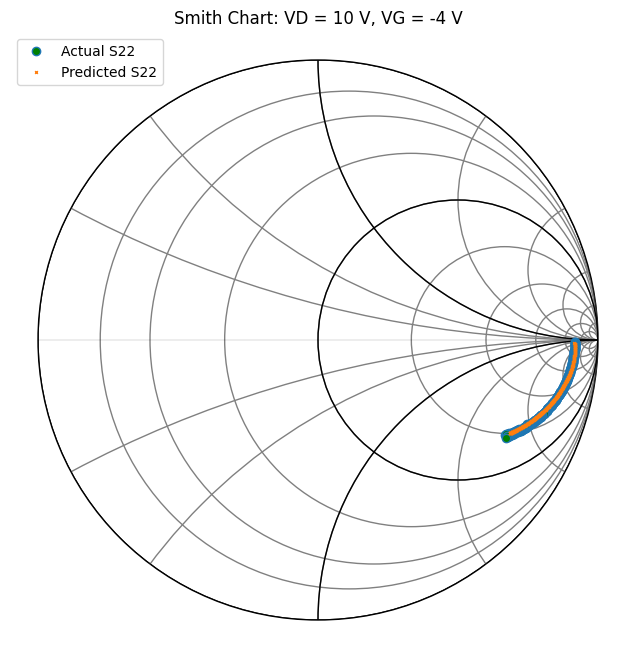

In [ ]:
plot_smith_for_vd_s22(7.5)

In [ ]:
# 1. Prepare S12 dataset for VG = -4V
X_train_s12 = X_train.copy()
X_test_s12  = X_test.copy()

y_train_s12 = train_df[['S12_real', 'S12_imag']].values
y_test_s12  = test_df [['S12_real', 'S12_imag']].values

# 2. Scale targets
scaler_y_s12    = StandardScaler().fit(y_train_s12)
y_train_s12_s   = scaler_y_s12.transform(y_train_s12)
y_test_s12_s    = scaler_y_s12.transform(y_test_s12)

# 3. Build & train model_s12
model_s12 = build_s11_model()  # same architecture
es_s12    = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_s12 = model_s12.fit(
    X_train_s,                     # scaled inputs from earlier
    [y_train_s12_s[:,0], y_train_s12_s[:,1]],
    validation_split=0,
    epochs=100,
    batch_size=8,
    callbacks=[es_s12],
    verbose=1
)

# 4. Predict & un-scale
pred_r_s12, pred_i_s12 = model_s12.predict(X_test_s)
pred_scaled_s12       = np.hstack([pred_r_s12, pred_i_s12])
pred_s12              = scaler_y_s12.inverse_transform(pred_scaled_s12)
pred_real_s12, pred_imag_s12 = pred_s12[:,0], pred_s12[:,1]

true_real_s12, true_imag_s12 = y_test_s12[:,0], y_test_s12[:,1]

# 5. Compute & print metrics
mre_real_s12 = mean_relative_error(true_real_s12, pred_real_s12)
mae_real_s12 = mean_absolute_error(    true_real_s12, pred_real_s12)
mse_real_s12 = mean_squared_error(    true_real_s12, pred_real_s12)

mre_imag_s12 = mean_relative_error(true_imag_s12, pred_imag_s12)
mae_imag_s12 = mean_absolute_error(    true_imag_s12, pred_imag_s12)
mse_imag_s12 = mean_squared_error(    true_imag_s12, pred_imag_s12)

print("\n=== VG = -4V, VD ∈ [0,8] Train/Test Split for S12 ===")
print(f"S12_real → MRE: {mre_real_s12:.6f}, MAE: {mae_real_s12:.6f}, MSE: {mse_real_s12:.6f}")
print(f"S12_imag → MRE: {mre_imag_s12:.6f}, MAE: {mae_imag_s12:.6f}, MSE: {mse_imag_s12:.6f}")


Epoch 1/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - imag_loss: 0.1961 - loss: 0.3576 - real_loss: 0.1615
Epoch 2/100
 61/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0551 - loss: 0.1107 - real_loss: 0.0556

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: imag_loss,loss,real_loss
  current = self.get_monitor_value(logs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0583 - loss: 0.1149 - real_loss: 0.0566
Epoch 3/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - imag_loss: 0.0470 - loss: 0.0963 - real_loss: 0.0493
Epoch 4/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0452 - loss: 0.0869 - real_loss: 0.0417
Epoch 5/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0304 - loss: 0.0535 - real_loss: 0.0231
Epoch 6/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0186 - loss: 0.0317 - real_loss: 0.0131
Epoch 7/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0150 - loss: 0.0264 - real_loss: 0.0114
Epoch 8/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0148 - loss: 0.0272 - real_loss: 0.0124
Epoch 9/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0122 - loss: 0.0227 - real_loss: 0.0105
Epoch 10/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0135 - loss: 0.0242 - real_loss: 0.0107
Epoch 11/100
522/522 ━━━━━━━━━━━━━━━━━━

In [ ]:
def plot_and_eval_for_vd_s12(vd_value, tol=1e-6):
    # filter VG=-4V, given VD, freq≤1.6e10
    subset_s12 = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.5e10)
    ]
    if subset_s12.empty:
        print(f"No data for VD={vd_value}V at VG=-4V"); return

    # inputs & predict
    X_sub_s12 = subset_s12[['Frequency','Drain Voltage']].values
    Xs_s12    = scaler_x.transform(X_sub_s12)
    pr_s12, pi_s12 = model_s12.predict(Xs_s12, verbose=0)
    ps_s12        = np.hstack([pr_s12, pi_s12])
    preds_s12     = scaler_y_s12.inverse_transform(ps_s12)
    pr12_r, pr12_i = preds_s12[:,0], preds_s12[:,1]

    # actual
    ar12_r = subset_s12['S12_real'].values
    ar12_i = subset_s12['S12_imag'].values
    fq_s12 = subset_s12['Frequency'].values

    # metrics
    def mre12(a,b): return np.mean(np.abs((a-b)/(a+1e-12)))
    mre_r12 = mre12(ar12_r, pr12_r)
    mre_i12 = mre12(ar12_i, pr12_i)
    mae_r12 = mean_absolute_error(ar12_r, pr12_r)
    mae_i12 = mean_absolute_error(ar12_i, pr12_i)
    mse_r12 = mean_squared_error(ar12_r, pr12_r)
    mse_i12 = mean_squared_error(ar12_i, pr12_i)

    print(f"\n[VD = {vd_value}V, VG = -4V]")
    print(f"S12_real → MRE:{mre_r12:.6f}, MAE:{mae_r12:.6f}, MSE:{mse_r12:.6f}")
    print(f"S12_imag → MRE:{mre_i12:.6f}, MAE:{mae_i12:.6f}, MSE:{mse_i12:.6f}")

    # plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fq_s12, ar12_r, 'o', label='Actual')
    plt.plot(fq_s12, pr12_r, 'x--', label='Predicted')
    plt.title(f'S12_real vs freq @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency'); plt.ylabel('S12_real'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(fq_s12, ar12_i, 'o', label='Actual')
    plt.plot(fq_s12, pr12_i, 'x--', label='Predicted')
    plt.title(f'S12_imag vs freq @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency'); plt.ylabel('S12_imag'); plt.legend()

    plt.tight_layout()
    plt.show()



[VD = 10V, VG = -4V]
S12_real → MRE:0.656977, MAE:0.001945, MSE:0.000006
S12_imag → MRE:0.057725, MAE:0.002326, MSE:0.000009


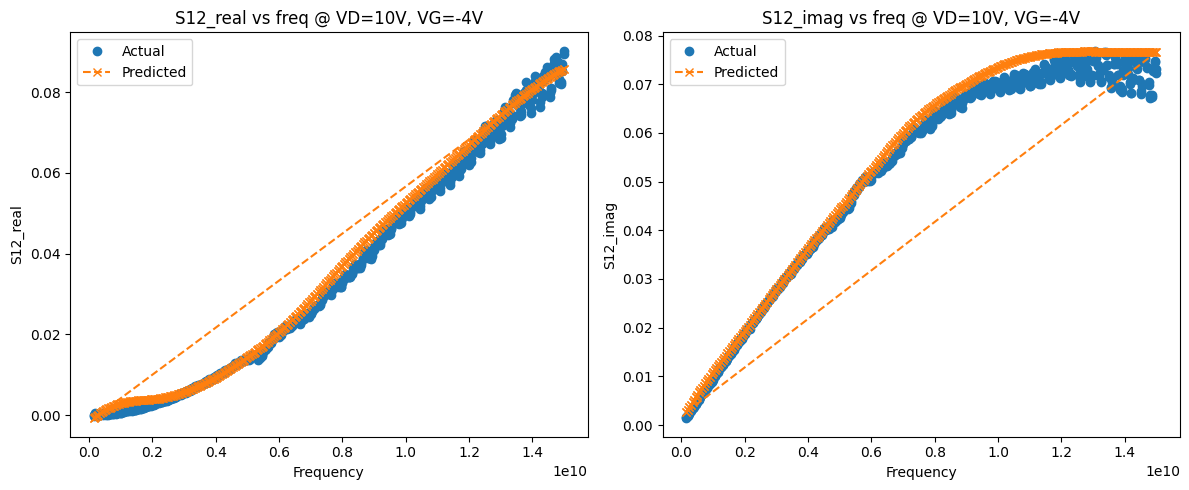

In [ ]:
plot_and_eval_for_vd_s12(10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_s12_db_for_vd(vd_value, tol=1e-6):
    """
    Plot actual vs. predicted |S12| in dB vs. Frequency for a given Drain Voltage,
    at fixed Gate Voltage = -4V.

    Relies on:
      - df           : original DataFrame with all S‑parameters
      - scaler_x     : StandardScaler fitted on [Frequency, Drain Voltage]
      - scaler_y_s12 : StandardScaler fitted on [S12_real, S12_imag]
      - model_s12    : trained Keras model predicting [S12_real, S12_imag]
    """
    # 1) Filter for VG = -4V, the requested VD, and remove high‑freq noise
    subset = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.6e10)
    ]
    if subset.empty:
        print(f"No data found for VD = {vd_value} V at VG = -4V")
        return

    # 2) Actual |S12| in dB
    freq = subset['Frequency'].values
    s12_act = subset['S12_real'].values + 1j * subset['S12_imag'].values
    s12_act_db = 20 * np.log10(np.abs(s12_act) + 1e-12)

    # 3) Predict (scale inputs → model → un‑scale outputs)
    X = subset[['Frequency', 'Drain Voltage']].values
    Xs = scaler_x.transform(X)
    pr, pi = model_s12.predict(Xs, verbose=0)
    preds_scaled = np.hstack([pr, pi])
    preds = scaler_y_s12.inverse_transform(preds_scaled)
    s12_pred = preds[:,0] + 1j * preds[:,1]
    s12_pred_db = 20 * np.log10(np.abs(s12_pred) + 1e-12)

    # 4) Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freq, s12_act_db, 'o-', label='Actual |S12| (dB)')
    plt.plot(freq, s12_pred_db, 'x--', label='Predicted |S12| (dB)')
    plt.title(f'S12 Magnitude (dB) vs Frequency @ VD = {vd_value} V, VG = -4 V')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S12| (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()


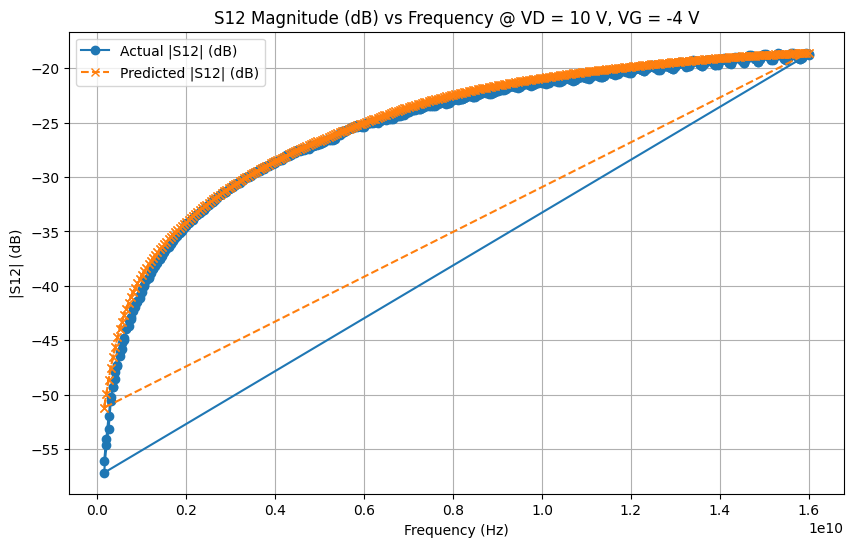

In [ ]:
plot_s12_db_for_vd(10)

In [ ]:
# 1. Prepare S21 dataset for VG = -4V
X_train_s21 = X_train.copy()
X_test_s21  = X_test.copy()

y_train_s21 = train_df[['S21_real', 'S21_imag']].values
y_test_s21  = test_df [['S21_real', 'S21_imag']].values

# 2. Scale targets
scaler_y_s21    = StandardScaler().fit(y_train_s21)
y_train_s21_s   = scaler_y_s21.transform(y_train_s21)
y_test_s21_s    = scaler_y_s21.transform(y_test_s21)

# 3. Build & train model_s21
model_s21 = build_s11_model()  # same architecture
es_s21    = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_s21 = model_s21.fit(
    X_train_s,                     # pre‑scaled inputs
    [y_train_s21_s[:,0], y_train_s21_s[:,1]],
    validation_split=0,
    epochs=200,
    batch_size=8,
    callbacks=[es_s21],
    verbose=1
)

# 4. Predict & un‑scale
pred_r_s21, pred_i_s21 = model_s21.predict(X_test_s)
pred_scaled_s21       = np.hstack([pred_r_s21, pred_i_s21])
pred_s21              = scaler_y_s21.inverse_transform(pred_scaled_s21)
pred_real_s21, pred_imag_s21 = pred_s21[:,0], pred_s21[:,1]

true_real_s21, true_imag_s21 = y_test_s21[:,0], y_test_s21[:,1]

# 5. Compute & print metrics
mre_real_s21 = mean_relative_error(true_real_s21, pred_real_s21)
mae_real_s21 = mean_absolute_error(    true_real_s21, pred_real_s21)
mse_real_s21 = mean_squared_error(    true_real_s21, pred_real_s21)

mre_imag_s21 = mean_relative_error(true_imag_s21, pred_imag_s21)
mae_imag_s21 = mean_absolute_error(    true_imag_s21, pred_imag_s21)
mse_imag_s21 = mean_squared_error(    true_imag_s21, pred_imag_s21)

print("\n=== VG = -4V, VD ∈ [0,8] Train/Test Split for S21 ===")
print(f"S21_real → MRE: {mre_real_s21:.6f}, MAE: {mae_real_s21:.6f}, MSE: {mse_real_s21:.6f}")
print(f"S21_imag → MRE: {mre_imag_s21:.6f}, MAE: {mae_imag_s21:.6f}, MSE: {mse_imag_s21:.6f}")


Epoch 1/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - imag_loss: 0.2293 - loss: 0.4385 - real_loss: 0.2092
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: imag_loss,loss,real_loss
  current = self.get_monitor_value(logs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0369 - loss: 0.0724 - real_loss: 0.0356
Epoch 3/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0259 - loss: 0.0471 - real_loss: 0.0212
Epoch 4/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0151 - loss: 0.0247 - real_loss: 0.0096
Epoch 5/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0140 - loss: 0.0228 - real_loss: 0.0088
Epoch 6/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0110 - loss: 0.0184 - real_loss: 0.0074
Epoch 7/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - imag_loss: 0.0085 - loss: 0.0150 - real_loss: 0.0065
Epoch 8/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - imag_loss: 0.0091 - loss: 0.0167 - real_loss: 0.0075
Epoch 9/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - imag_loss: 0.0094 - loss: 0.0150 - real_loss: 0.0057
Epoch 10/200
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - imag_loss: 0.0075 - loss: 0.0134 - real_loss: 0.0059
Epoch 11/200
522/522 ━━━━━━━━━━━━━━━━━━

In [ ]:
def plot_and_eval_for_vd_s21(vd_value, tol=1e-6):
    # filter VG=-4V, given VD, freq≤1.6e10
    subset_s21 = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.4e10)
    ]
    if subset_s21.empty:
        print(f"No data for VD={vd_value}V at VG=-4V")
        return

    # inputs & predict
    X_sub_s21 = subset_s21[['Frequency','Drain Voltage']].values
    Xs_s21    = scaler_x.transform(X_sub_s21)
    pr_s21, pi_s21 = model_s21.predict(Xs_s21, verbose=0)
    ps_s21         = np.hstack([pr_s21, pi_s21])
    preds_s21      = scaler_y_s21.inverse_transform(ps_s21)
    pr21_r, pr21_i = preds_s21[:,0], preds_s21[:,1]

    # actual
    ar21_r = subset_s21['S21_real'].values
    ar21_i = subset_s21['S21_imag'].values
    fq_s21 = subset_s21['Frequency'].values

    # metrics
    def mre21(a,b): return np.mean(np.abs((a-b)/(a+1e-12)))
    mre_r21 = mre21(ar21_r, pr21_r)
    mre_i21 = mre21(ar21_i, pr21_i)
    mae_r21 = mean_absolute_error(ar21_r, pr21_r)
    mae_i21 = mean_absolute_error(ar21_i, pr21_i)
    mse_r21 = mean_squared_error(ar21_r, pr21_r)
    mse_i21 = mean_squared_error(ar21_i, pr21_i)

    print(f"\n[VD = {vd_value}V, VG = -4V]")
    print(f"S21_real → MRE:{mre_r21:.6f}, MAE:{mae_r21:.6f}, MSE:{mse_r21:.6f}")
    print(f"S21_imag → MRE:{mre_i21:.6f}, MAE:{mae_i21:.6f}, MSE:{mse_i21:.6f}")

    # plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fq_s21, ar21_r, 'o', label='Actual')
    plt.plot(fq_s21, pr21_r, 'x--', label='Predicted')
    plt.title(f'S21_real vs freq @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency'); plt.ylabel('S21_real'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(fq_s21, ar21_i, 'o', label='Actual')
    plt.plot(fq_s21, pr21_i, 'x--', label='Predicted')
    plt.title(f'S21_imag vs freq @ VD={vd_value}V, VG=-4V')
    plt.xlabel('Frequency'); plt.ylabel('S21_imag'); plt.legend()

    plt.tight_layout()
    plt.show()



[VD = 8.5V, VG = -4V]
S21_real → MRE:0.008138, MAE:0.010519, MSE:0.000154
S21_imag → MRE:0.063958, MAE:0.014941, MSE:0.000328


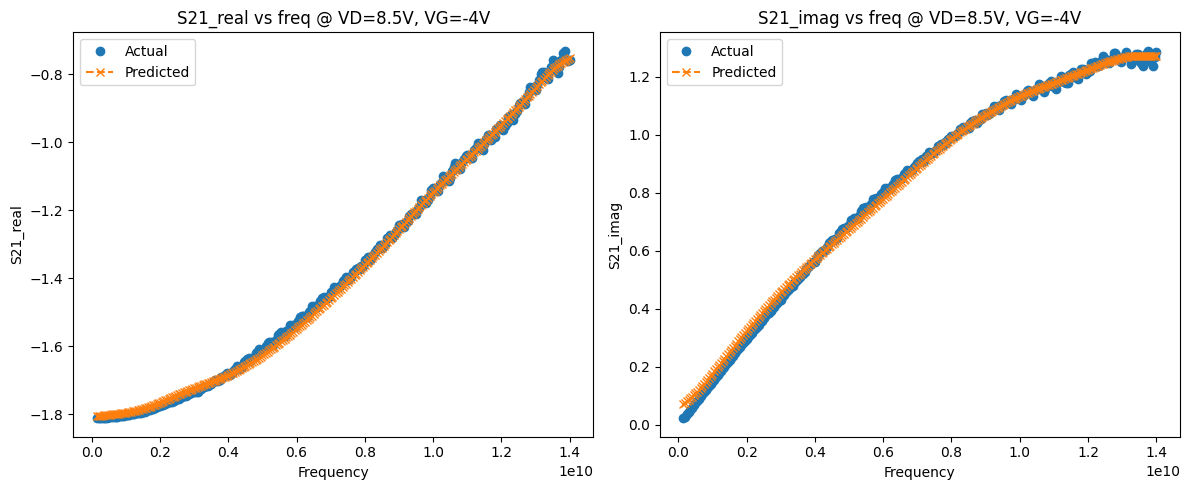

In [ ]:
plot_and_eval_for_vd_s21(8.5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_s21_db_for_vd(vd_value, tol=1e-6):
    """
    Plot actual vs. predicted |S21| in dB vs. Frequency for a given Drain Voltage.
    """
    subset = df[
        (np.abs(df['Drain Voltage'] - vd_value) < tol) &
        (df['Gate Voltage'] == -4) &
        (df['Frequency'] <= 1.4e10)
    ]
    if subset.empty:
        print(f"No data for VD = {vd_value} V at VG = -4V")
        return

    freq = subset['Frequency'].values
    s21_act = subset['S21_real'].values + 1j*subset['S21_imag'].values
    s21_act_db = 20 * np.log10(np.abs(s21_act) + 1e-12)

    X = subset[['Frequency','Drain Voltage']].values
    Xs = scaler_x.transform(X)
    pr, pi = model_s21.predict(Xs, verbose=0)
    ps = np.hstack([pr, pi])
    preds = scaler_y_s21.inverse_transform(ps)
    s21_pred = preds[:,0] + 1j*preds[:,1]
    s21_pred_db = 20 * np.log10(np.abs(s21_pred) + 1e-12)

    plt.figure(figsize=(10,6))
    plt.plot(freq, s21_act_db, 'o-', label='Actual |S21| (dB)')
    plt.plot(freq, s21_pred_db, 'x--', label='Predicted |S21| (dB)')
    plt.title(f'S21 Magnitude (dB) vs Frequency @ VD = {vd_value} V, VG = -4 V')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S21| (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()


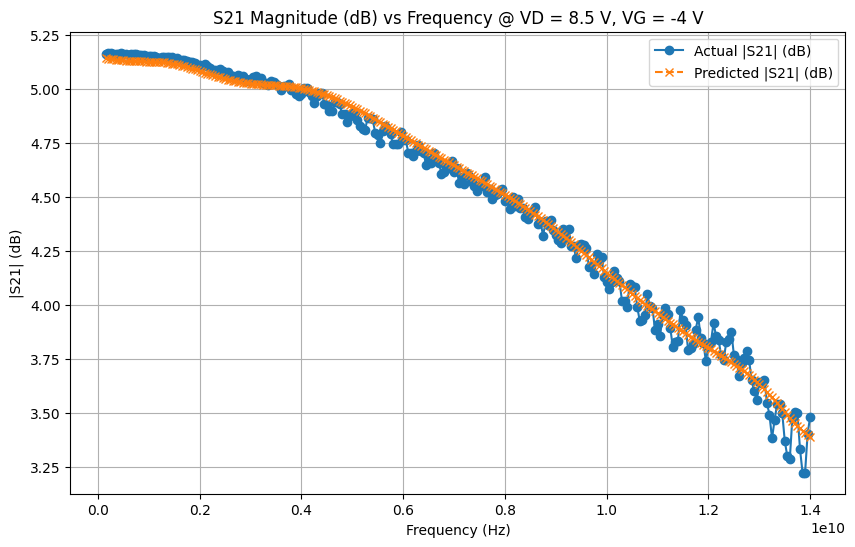

In [ ]:
plot_s21_db_for_vd(8.5)